In [14]:
from pathlib import Path
import shutil
import os


ROOT_DATA_DIR = Path("/home/avishkar/Desktop/research/driving_dataset")
DATA_DIR = Path("/home/avishkar/Desktop/research/driving_dataset_preprocessed_2")
EXP_DIR = Path("/home/avishkar/Desktop/research/experiments")
    
print("Len dataset : ",len(os.listdir(DATA_DIR)))

Len dataset :  45569


In [40]:
# Vis data

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

class DrivingDataset(Dataset):
    def __init__(self, labels_path, data_dir, transform=None):
        with open(Path(labels_path), "r") as f:
            self.labels = f.readlines()
            f.close()
        self.data_dir = Path(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index) :
        img_path, label = self.labels[index].split()
        label=float(label)*np.pi/180
        img = Image.open(self.data_dir/img_path)
        width, height = img.size
        img = img.crop((0, 150, width, height))

        if self.transform:
            img = self.transform(img)

        return (img, label)
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((66,200)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

BATCH_SIZE = 32
NUM_WORKERS = 2

from torchvision import datasets

dataset = DrivingDataset(labels_path=ROOT_DATA_DIR/"data.txt", data_dir=ROOT_DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = int(len(dataset)-train_size)
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

print(f"train : {len(train_set)}, test: {len(test_set)}")




train : 36324, test: 9082


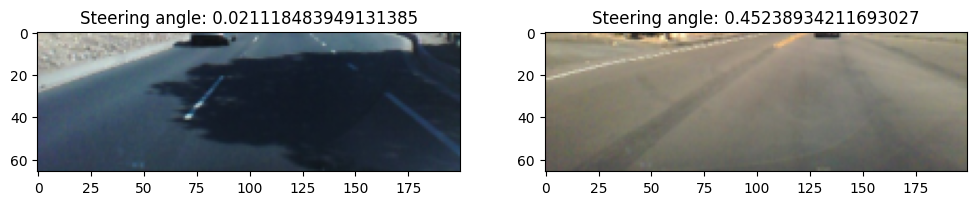

In [41]:
for i, (imgs, labels) in enumerate(train_loader):
    # img = imgs[0]
    label = labels[0]
    
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title(f"Steering angle: {labels[0].item()}")
    ax1.imshow(imgs[0].permute(1,2,0))

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title(f"Steering angle: {labels[1].item()}")
    ax2.imshow(imgs[1].permute(1,2,0))
    
    # plt.axis('off')
    plt.show()
    break

In [84]:
# model

import torch.nn as nn 
import torch
from torchsummary import summary

class DAVE2_mark1(nn.Module):
    def __init__(self):
        super(DAVE2_mark1, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 1 * 18, 100)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 50)
        self.dropout3 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        # print(x.shape)
        x = torch.relu(self.conv5(x))
        # print(x.shape)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)
        return x

model = DAVE2_mark1()
summary(model, (3,66,200))
# print(dir(model))

torch.Size([2, 64, 3, 20])
torch.Size([2, 64, 1, 18])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 31, 98]           1,824
            Conv2d-2           [-1, 36, 14, 47]          21,636
            Conv2d-3            [-1, 48, 5, 22]          43,248
            Conv2d-4            [-1, 64, 3, 20]          27,712
            Conv2d-5            [-1, 64, 1, 18]          36,928
           Flatten-6                 [-1, 1152]               0
           Dropout-7                 [-1, 1152]               0
            Linear-8                  [-1, 100]         115,300
           Dropout-9                  [-1, 100]               0
           Linear-10                   [-1, 50]           5,050
          Dropout-11                   [-1, 50]               0
           Linear-12                    [-1, 1]              51
Total params: 251,749
Trainable params: 251,749
N


processing...

(66, 200)
(31, 98)
(14, 47)
(5, 22)
(3, 20)
(1, 18)


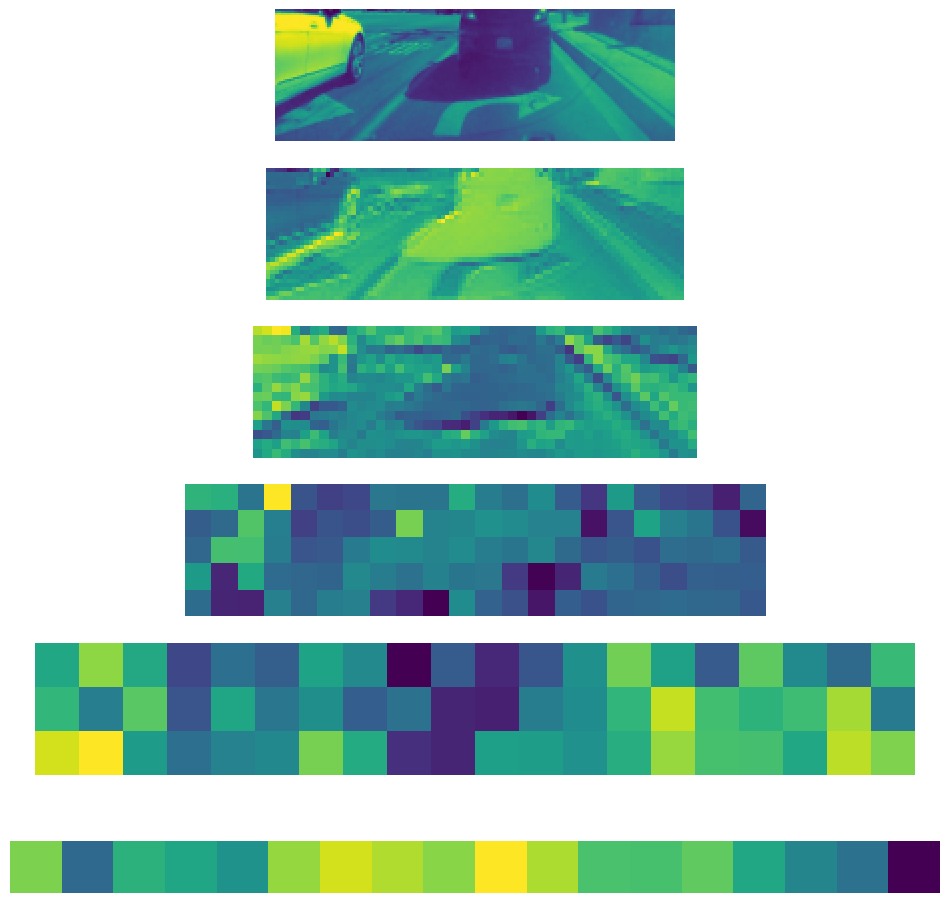

In [86]:
# vis internal cnn image vis
#https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573    

# x = torch.randn((1,3,66,200))

outputs = []
data = iter(train_loader)
imgs, labels = next(data)
img = imgs[0].reshape(1,3,66,200)
# print("img initial shape : ",img.shape)

outputs.append(img)
for module in model.children():
    img  = module(img)
    outputs.append(img)
    # print(img.shape)

# convert 3d tensors to 2d shape
print("\nprocessing...\n")
processed = []
for feat_map in outputs:
  feat_map  = feat_map.squeeze(0)
  gray_scale = torch.sum(feat_map, 0)
  gray_scale = gray_scale / feat_map.shape[0]
  if(gray_scale.shape):
    processed.append(gray_scale.detach().numpy())
  
for fm in processed:
    print(fm.shape)


# plot
fig = plt.figure(figsize= (12,12))
for i in range(len(processed)):
  a = fig.add_subplot(len(processed), 1, i+1)
  a.imshow(processed[i])
  a.axis("off")